<a href="https://colab.research.google.com/github/SanjibSarkarU/colab-NN/blob/main/rnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df = pd.read_csv('20220222_153859_hlc.csv', skiprows=1)
df = df.rename(columns={"Latitude (Deg N)": 'lat', "Longitude (Deg W)": 'lng'}, errors="raise")
df = df.loc[(df['lat'] != 0)]
# df.head(5)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
window_size = 15
batch_size = 32
shuffle_buffer_size = 100

In [6]:
start = 8500
end = 13700
series_time = df.Time[start:end]
series_lat = df.lat[start:end]
series_lng = df.lng[start:end]

series_time = series_time.to_numpy()
series_lat = series_lat.to_numpy()
series_lng = series_lng.to_numpy()

In [7]:
split_time = 3900
time_train = series_time[:split_time]
x_train_lat = series_lat[:split_time]
x_train_lng = series_lng[:split_time]

time_valid = series_time[split_time:]
x_valid_lat = series_lat[split_time:]
x_valid_lng = series_lng[split_time:]
print(f'total: {len(series_lat)}, x_train_lat:{len(x_train_lat)}, x_valid_lat:{len(x_valid_lat)}')


total: 5200, x_train_lat:3900, x_valid_lat:1300


In [ ]:
train_set = windowed_dataset(x_train_lat, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

(1e-08, 0.0001, 0.0, 30.0)

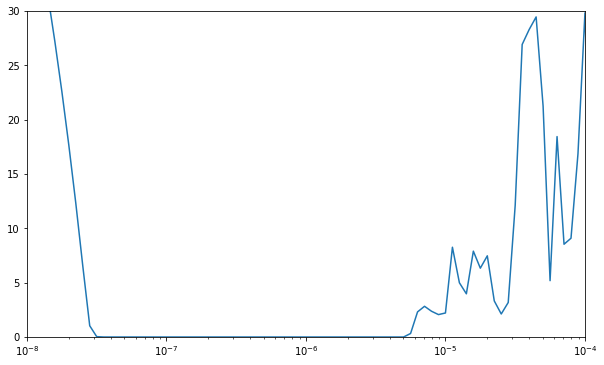

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train_lat, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=5e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

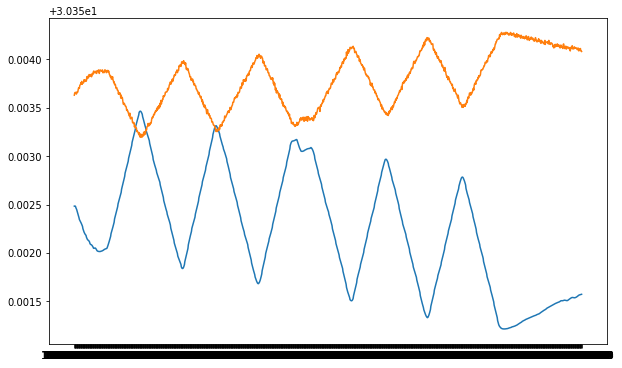

In [13]:
forecast=[]
for time in range(len(series_lat) - window_size):
  forecast.append(model.predict(series_lat[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plt.plot(time_valid, x_valid_lat)
plt.plot(time_valid, results)

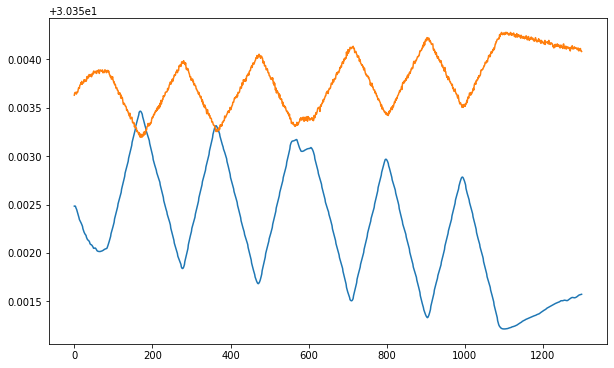

In [14]:

plt.figure(figsize=(10, 6))

plt.plot(x_valid_lat)
plt.plot(results)